# Implementing an AI for the Board Game Abalone


Ben Minogue

## Introduction

Abalone, invented in 1987 by Michel Lalet and Laurent Levi, is a popular 2 player abstract board game that as of today has sold over 12 million copies nationwide[1]. Earlier this year, i created a user friendly digital version of this game using a package called Pygame in Python. The game includes a player v player mode, a player vs AI mode, 61 completable levels and a "sandbox" mode so the board can be set up however a player likes to better analyse positions.

The main objective for this project is to create an AI for my game so  humans can play against it. This AI must be as competative as possible, be adaptable to the different level set ups, and be able to play a move in under 5 seconds to maintain player interest. An appropriate choice of AI alogorithm is Minimax with Alpha-Beta pruning. This is because it does not require training on a starting position so it is just as useful in any board position, it can be made to give a move in any specified time limit with the help of an iterative deepener, and it is by far the most popular and competative algorithm for Abalone with the current Abalone AI champion "Abapro" utilising this method. Other options of algorithm would be a Monte Carlo type search tree or somthing invlolving neural networks and reinforcment leaning. However when competing with other methods Minimax tends to come out on top [4]



In this project I will explain the rules and basic strategies in Abalone, I will give my Minimax implementation and comment on various optimization strategies used such as Alpha-Beta Pruning, Zobrist Hashing, Move Ordering, Iterative Deepening and the Killer Move Heuristic.
I will also compare the two predominant strategies in Abalone, namely compactness and center control, by editing the evaluation function and battling the AI against itself in an attempt to find the optimum ratio between the two strategies. 

## Abalone

### Rules of Abalone

Starting from an agreed upon symmetrical starting position (traditionally with 14 marbles each), each player takes a turn with black going first. In a turn, the player can move one, two or three inline-marbles in any of the 6 hexagonal directions provided there is room on the board. If 2 marbles are moved "inline" and there is an opponant marble in the way, this marble can be pushed in the same direction. If 3 marbles are moved "inline" and there are one or two opponant marbles in the way, these can also be pushed. Pushing cannot happen in "slide" moves (Figures 1 and 3). These moves are shown below with green spots representing an "inline" move, blue spots representing a "slide" move and red spots representing a "push" move. The game is won when a player has successfully pushed 6 opponant marbles off the board.



</figure>
    <div style="display: flex; flex-direction: column; align-items: center;">
        <table>
          <tr>
            <td>
                <img src='inline_slide.jpg' alt="image-2" width="40%" height="40%" style="width:300px; height:350px; object-fit:none; object-position:33.33% 0;">
              <figcaption style="text-align:center; display:block; font-size:16px;">
                  <strong style="font-size:16px; font-weight:bold;">Figure 1.</strong> possible inline move (green)<br> and slide moves (blue) for three piece</figcaption>
              </td>
            <td>
                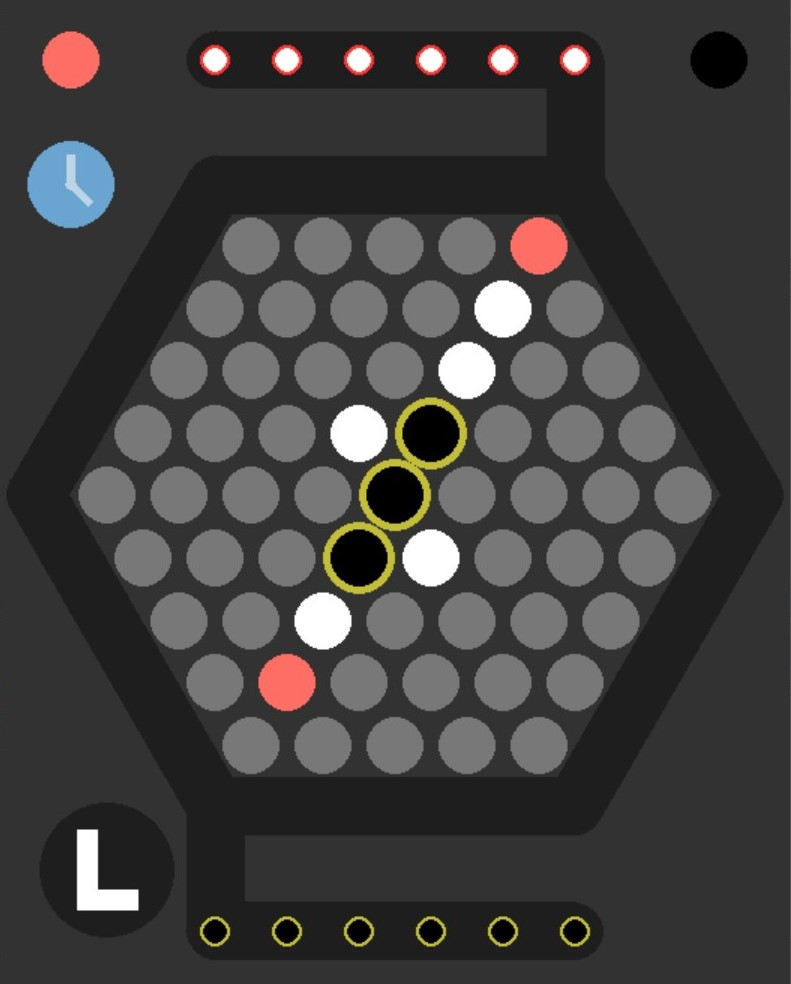
              <figcaption style="text-align:center; display:block; font-size:16px;">
                  <strong style="font-size:16px; font-weight:bold;">Figure 2.</strong> possible push moves for three piece</figcaption>
              </td>
            <td>
                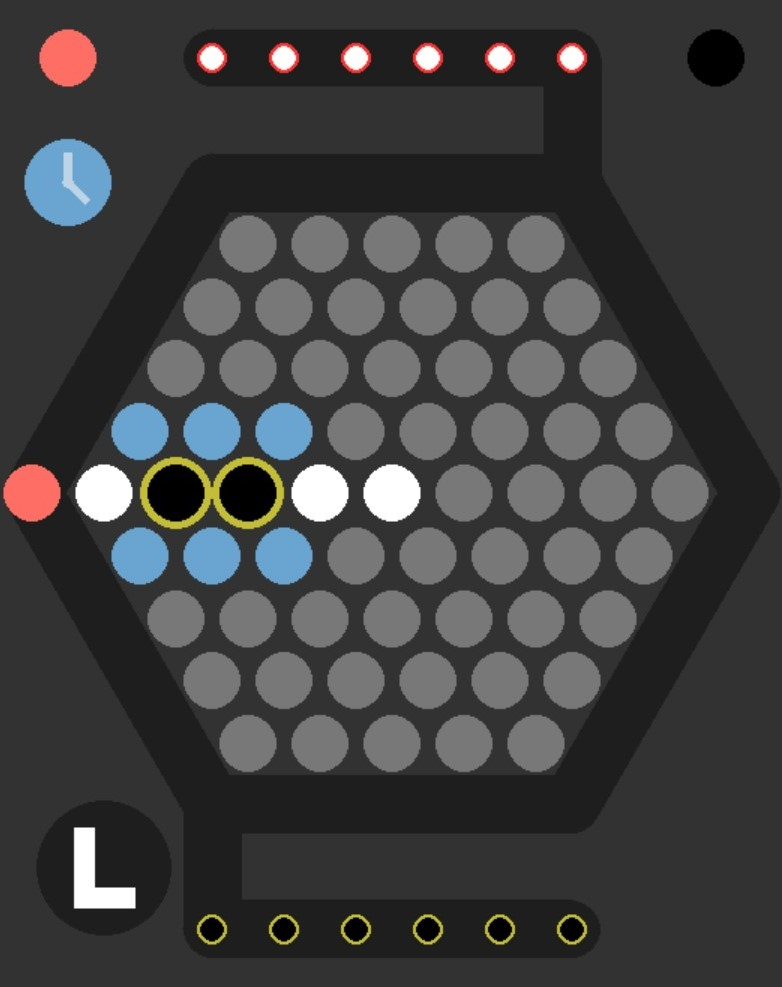
              <figcaption style="text-align:center; display:block; font-size:16px;">
                  <strong style="font-size:16px; font-weight:bold;">Figure 3.</strong> possible "knock" move (red)<br> and slide moves (blue) for two piece</figcaption>
              </td>
          </tr>
        </table>
    </div>
</figure>

### Winning Strategies

To win the game, one must make a compromise between aggressivly pushing opponant marbles and at the same time protecting one's own marbles from being pushed off. Upon reviewing various Abalone papers and discussion forums[2] the main strategies emerge as:

1. Keep our marbles around the middle of the board and force the opponent to move towards the edges.

2. Keep our marbles together as much as possible and set out to separate and isolate opponant marbles.

There are other strategies such as maximising our number of "3s in a row" or positioning marbles specifically to disrupt enemy development. However in this project we will focus on the two main strategies. These strategies are fundamental in many top existing Abalone AIs. Most notably ABLA is considered to play at a high dificulty level with only these two strategies present in the evaluation function [3]

## Minimax

Minimax is the typical algorithm of choice for two-player perfect information games such as Abalone. Traditionally, Minimax searches an entire game tree for all terminal states and suggests the move most likely to lead to a terminal state where the maximising player wins. It does this by considereing every possible move for the maximising player, then every possible move for the minimising player in these positions, then every possible move for the maximising player in these positions and so on until all terminal states have been found.

Such an approach is possible in simple games such as Noughts and Crosses (easily) or Connect 4 (if lots of optimization is used). However for games such as Abalone, Chess and Go, the game tree complexity is much too large for the entire tree to be explored even with all know optimiztion strategies implemented.

Because of this we are forced to limit our search to a certain depth and evaluate the game state based on multiple heuristics and metrics given by known strategies and knowledge of the game. If we are looking at moves for the maximising player, the move leading to the best board state is suggested along with the score of the board in that position. If we are looking at moves for the minimising (opposition) player, the move leading to the board with the minumum score is suggested as this represents the best move your opponant can play in this position, and it has to be assumed your opponant will play the best move.

### Minimax in Abalone

Abalone has a game tree complexity of 60 [5] which is high compared to comparable games such as Chess and Draughts. The game tree complexity is the average number of moves that can be played in a given position. A game tree complexity of 60 means that just to evaluate at depth 3 requires 22,320 evaluations, sometimes many more. Beacuse of this, the main focus of Minimax is optimization. There are countless optimization strategies that can be used for Minimax, in the next section we present 4 strategies used to gurentee the algorithm gives a move in under 5 seconds and analyse the effectiveness of these strategies. For now, here is the skeleton minimax algorithm code with no optimization strategies in place.

In [7]:
def Minimax_plain(positions, depth, my_lives, opp_lives, move_num, piece, maximising):
    if piece == 2:
        opp_piece = 3
    elif piece == 3:
        opp_piece = 2
    # this is a winning terminal state, so we give massive reward
    if opp_lives == 0:
        return None, 9999999999
    # losing terminal state, give massive punishment
    elif my_lives == 0:
        return None, -9999999999
    # if not terminal state, evaluate board position
    elif depth == 0:
        return None, AI.evaluate_pos(positions, my_lives, opp_lives, alpha, piece)
    # If maximising player
    if maximising:
        # get all player moves
        valid_moves, valid_shoves, valid_knocks = AI.get_all_moves(positions, piece, opp_piece)
        value = -math.inf
        for move in valid_moves:
            # update board position with move
            positions = AI.play_move_position(positions, move, piece, opp_piece)
             # if its a knock we take a life off the opponant
            if move in valid_knocks:
                new_score = Minimax_plain(positions, depth - 1, my_lives, opp_lives - 1, move_num, piece, False)[1]
            else:
                # recursive call, but this time minimising player as it is their turn next 
                new_score = Minimax_plain(positions, depth - 1, my_lives, opp_lives, move_num, piece, False)[1]
            # put board back to how it was, ready for next move to be tested
            positions = AI.undo_move_position(positions, move, piece, opp_piece)
            # find maximum score and best move associated
            if new_score > value:
                value = new_score
                best_move = move
        return best_move, value
    # If minimising player
    else:
        # get moves for opposition player
        valid_moves, valid_shoves, valid_knocks = AI.get_all_moves(positions, opp_piece, piece)
        value = math.inf
        for move in valid_moves:
            positions = AI.play_move_position(positions, move, opp_piece, piece)
            if move in valid_knocks:
                new_score = Minimax_plain(positions, depth - 1, my_lives - 1, opp_lives, move_num, piece, True)[1]
            else:
                new_score = Minimax_plain(positions, depth - 1, my_lives, opp_lives, move_num, piece, True)[1]
            positions = AI.undo_move_position(positions, move, opp_piece, piece)
            if new_score < value:
                value = new_score
                best_move = move
        return best_move, value

## Minimax Optimization

The paper "Implementing a Computer Player for Abalone using Alpha-Beta and Monte-Carlo Search" by Pascal Chorus [4] was very useful in the implementation of these optimization strategies, specifically Zobrist hashing.


### Alpha-Beta Pruning

Alpha-Beta Pruning is a technique that involves cutting off branches of the game tree that are not worth evaluating. For example, if we have already evaluated a position to have a score of +10, lets say that in the new position we are evaluating the opponant has a move that if played will only give us a score of +8, it is pointless to continue searching for outcomes down this path as we know a better outcome can be gurenteed with the first move. Therefore we can prune the rest of this branch and start looking for a new first move. This is by far the best optimization strategy and most other strategies focus on improving the effectivness of the pruning. Below is my implementation.

In [9]:
import math

# Alpha and Beta initialised as follows
alpha = -math.inf
beta = math.inf

def Minimax_AB(positions, depth, alpha, beta, my_lives, opp_lives, move_num, piece, maximising):
    if piece == 2:
        opp_piece = 3
    elif piece == 3:
        opp_piece = 2
    # this is a winning terminal state, so we give massive reward
    if opp_lives == 0:
        return None, 9999999999
    # losing terminal state, give massive punishment
    elif my_lives == 0:
        return None, -9999999999
    # if not terminal state, evaluate board position
    elif depth == 0:
        return None, AI.evaluate_pos(positions, my_lives, opp_lives, a, piece)
    # If maximising player
    if maximising:
        valid_moves, valid_shoves, valid_knocks = AI.get_all_moves(positions, piece, opp_piece)
        value = -math.inf
        for move in valid_moves:
            positions = AI.play_move_position(positions, move, piece, opp_piece)
            if move in valid_knocks:
                new_score = Minimax_AB(positions, depth - 1, alpha, beta, my_lives, opp_lives - 1, move_num, piece, False)[1]
            else:
                new_score = Minimax_AB(positions, depth - 1, alpha, beta, my_lives, opp_lives, move_num, piece, False)[1]
            positions = AI.undo_move_position(positions, move, piece, opp_piece)
            if new_score > value:
                value = new_score
                best_move = move
            # alpha given value of current best possible score
            # we can stop looking for moves in this direction if alpha > beta
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return best_move, value
    # If minimising player
    else:
        # get oposition players moves
        valid_moves, valid_shoves, valid_knocks = AI.get_all_moves(positions, opp_piece, piece)
        value = math.inf
        for move in valid_moves:
            positions = AI.play_move_position(positions, move, opp_piece, piece)
            if move in valid_knocks:
                new_score = Minimax_AB(positions, depth - 1, alpha, beta, my_lives - 1, opp_lives, move_num, piece, True)[1]
            else:
                new_score = Minimax_AB(positions, depth - 1, alpha, beta, my_lives, opp_lives, move_num, piece, True)[1]
            positions = AI.undo_move_position(positions, move, opp_piece, piece)
            if new_score < value:
                value = new_score
                best_move = move
            # beta given value of current worst possible score, representing minimising players best move  
            # we can stop looking for moves in this direction if alpha > beta
            beta = min(beta, value)
            if alpha >= beta:
                break
        return best_move, value

### Move Ordering

Move ordering is one of the techniques used to increase the effectiveness of alpha beta pruning. It involves checking the "likely" best moves first in the hope of pruning more branches. the order found to lead to the most prunings by Pascal Chorus[4] is 3 "capture" move, 2 "capture" move, 3 "knock" move, 2 "knock" move,  3 inline push, 2 inline push, 3 slide, 2 slide, single. This move ordering must be implemented in the get_all_moves() function so as not to waste anymore time in minimax.

### Zobrist Hashing

Zobrist hashing is an effective optimization stategy, especially on higher depths. The process involves recording the value of a board state when it is evaluated so that if the board state is come across again in a different move order instead of continuing to evaluate recursilvly, we can check the hash table to see if the board has a value stored and if it does we use this value. A board state is given a key by XORing all the piece positions and the number of white and black lives remaining. This key can be looked up very quickly speeding up the process if a board state has already been evaluated. This technique could be further improved by storing all possible available moves for both players in a given board position and accessing this rather than calling get_all_moves() as this is a costly function. 

In [12]:
import random 
    
# not the dimensions of an Abalone board but the dimensions of my display
ROW_COUNT = 15
COLUMN_COUNT = 10
# Initialize the Zobrist keys
zobrist_keys = [[0 for j in range(COLUMN_COUNT)] for i in range(ROW_COUNT)]
for i in range(ROW_COUNT):
    for j in range(COLUMN_COUNT):
        # need 4 values for game state representing black position, white positions, black lives, white lives
        zobrist_keys[i][j] = [random.randint(0, 2**64-1), random.randint(0, 2**64-1), random.randint(0, 2**64-1), random.randint(0, 2**64-1)]

def generate_zobrist_key(positions):
    """
    Generates a Zobrist key for the given board state.
    """
    key = 0
    for marble in positions:
        piece_index = marble[0] - 2
        # XOR positions together to create key for position
        key ^= zobrist_keys[marble[1]][marble[2]][piece_index]
    return key

# zobrist table initialised as {}
def Minimax_ABZ(positions, depth, alpha, beta, my_lives, opp_lives, move_num, piece, maximising, zobrist_table):
    # generate zobrist key for this board state
    board_key = generate_zobrist_key(positions) 
    if piece == 2:
        opp_piece = 3
    elif piece == 3:
        opp_piece = 2
    if opp_lives == 0:
        return None, 9999999999
    elif my_lives == 0:
        return None, -9999999999
    elif depth == 0:
        if board_key in zobrist_table:
            return zobrist_table[board_key]
        else:
            pos_score = AI.evaluate_pos2(positions, my_lives, opp_lives, move_num, piece)
            # whenever a board is evaluated its score is saved
            key = AI.generate_zobrist_key(positions)
            zobrist_table[key] = None, pos_score
            return None, pos_score
    if maximising:
        valid_moves, valid_shoves, valid_knocks = AI.get_all_moves(positions, piece, opp_piece)
        value = -math.inf
        for move in valid_moves:
            positions = AI.play_move_position(positions, move, piece, opp_piece)
            board_key = AI.generate_zobrist_key(positions)
            # check if position is in zobrist table before evaluating recursivly
            if board_key in zobrist_table:
                new_score = zobrist_table[board_key][1]
            else:
                if move in valid_knocks:
                    new_score = Minimax_ABZ(positions, depth - 1, alpha, beta, my_lives, opp_lives - 1, move_num, piece, False, zobrist_table)[1]
                else:
                    new_score = Minimax_ABZ(positions, depth - 1, alpha, beta, my_lives, opp_lives, move_num, piece, False, zobrist_table)[1]
            positions = AI.undo_move_position(positions, move, piece, opp_piece)
            if new_score > value:
                value = new_score
                best_move = move
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return best_move, value

    else:
        valid_moves, valid_shoves, valid_knocks = AI.get_all_moves(positions, opp_piece, piece)
        get_moves_call += 1
        value = math.inf
        for move in valid_moves:
            positions = AI.play_move_position(positions, move, opp_piece, piece)
            board_key = AI.generate_zobrist_key(positions)
            # again, check if position was already evaluated
            if board_key in zobrist_table:
                new_score = zobrist_table[board_key][1]
            else:
                if move in valid_knocks:
                    new_score = Minimax_ABZ(positions, depth - 1, alpha, beta, my_lives - 1, opp_lives, move_num, piece, True, zobrist_table)[1]
                else:
                    new_score = Minimax_ABZ(positions, depth - 1, alpha, beta, my_lives, opp_lives, move_num, piece, True, zobrist_table)[1]
            positions = AI.undo_move_position(positions, move, opp_piece, piece)
            if new_score < value:
                value = new_score
                best_move = move
            beta = min(beta, value)
            if alpha >= beta:
                break
        return best_move, value

### Iterative Deepening with Killer Move

Iterative deepening is arguably the most important optimization strategy used in this project other than pruning. The implementation allows the user to set a timelimit which will always be met provided the AI can conduct a search of depth 2 in this time. After a search at depth 1 and depth 2 is completed the function uses the ratio of how long each search took to predict how long a search at depth 3 will take. It compares this value with the time left to decide if there is time for a search at depth 3. If there is, it will complete the search and then iterativly repeat the process to decide if there is time for a search at depth 4. This strategy is massivly important as in the later stages of the game there are less moves available dues to marbles being knocked off and/or bunched together which gives the AI an opportunity to explore at a higher depth. It may seem like alot of time is wasted evaluating at depth 1 and 2. However, as we will see in the analysis, depth 1 takes practically no time to evaluate and depth 2 provides a useful tradeoff with the time wasted on it by providing the search at depth 3 with a "killer move". This killer move is what the search at depth 2 decided to be the best move in the position, it is passed into the minimax search at depth 3 and will be checked first leading to massive prunings and speeding up the search. The zobrist table is also passed down to help speed up board evaluations.

In [14]:
def iterative_deepener(timelimit, positions, my_lives, opp_lives, move_num, piece):
    zobrist_table = {}
    # perform search at depth 1 and time it
    starttime1 = time.time()
    best_move, score = AI.MinimaxABZ(positions, 1, -math.inf, math.inf, my_lives, opp_lives, move_num, piece, True, zobrist_table)
    endtime1 = time.time()
    time_passed1 = endtime1 - starttime1
    
    # perform search at depth 2 and time it
    starttime2 = time.time()
    killer_move, score = AI.MinimaxABZ(positions, 2, -math.inf, math.inf, my_lives, opp_lives, move_num, piece, True, zobrist_table)
    endtime2 = time.time()
    time_passed2 = endtime2 - starttime2
    if time_passed1 != 0:
        ratio = time_passed2 / time_passed1
    else:
        ratio = 1
    time_left = timelimit - time_passed1 - time_passed2
    best_move = killer_move
    depth = 3
    # if time left perform another search at higher depth
    while time_left - time_passed2 * ratio > 0:
        starttime3 = time.time()
        best_move, score = AI.MinimaxABZK(positions, depth, alpha, beta, my_lives, opp_lives, move_num, piece, True, {}, killer_move)
        endtime3 = time.time()
        time_passed3 = endtime3 - starttime3
        time_left -= time_passed3
        time_passed1 = time_passed2
        time_passed2 = time_passed3
        ratio = time_passed2 / time_passed1
        depth += 1


    return best_move, score

### Analysis of Optimization Strategies

In the tables below we show the average number of board evaluations, the average number of times the list of possible moves was generated, and the average total time the algorithm took to produce a move, over the course of a full game. These values can be as much as 3 times as high early in the game and as little as a third as high at the end of the game. The moves are already ordered in all four functions.

<figure>
    <table>
      <thead>
        <tr>
          <th>Depth</th>
          <th>Plain Minimax</th>
            <th>AB Pruning</th>
            <th>Pruning and Hashing</th>
            <th>Iterative Deepener</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>1</td>
          <td>57</td>
            <td>57</td>
            <td>57</td>
            <td>NA</td>
        </tr>
        <tr>
          <td>2</td>
          <td>3430</td>
            <td>637</td>
            <td>637</td>
            <td>NA</td>
        </tr>
        <tr>
          <td>3</td>
          <td>160968</td>
            <td>12495</td>
            <td>7232</td>
            <td>879</td>
        </tr>
      </tbody>
    </table>
    <figcaption style="text-align:center; display:block; font-size:16px;">
                  <strong style="font-size:16px; font-weight:bold;">Figure 4.</strong> Average Number of Board Evaluations </figcaption>
<figure>


    
    

<figure>
    <table>
      <thead>
        <tr>
          <th>Depth</th>
          <th>Plain Minimax</th>
            <th>AB Pruning</th>
            <th>Pruning and Hashing</th>
            <th>Iterative Deepener</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>1</td>
          <td>1</td>
            <td>1</td>
            <td>1</td>
            <td>NA</td>
        </tr>
        <tr>
          <td>2</td>
          <td>59</td>
            <td>59</td>
            <td>59</td>
            <td>NA</td>
        </tr>
        <tr>
          <td>3</td>
          <td>2895</td>
            <td>575</td>
            <td>485</td>
            <td>86</td>
        </tr>
      </tbody>
    </table>
    <figcaption style="text-align:center; display:block; font-size:16px;">
                  <strong style="font-size:16px; font-weight:bold;">Figure 5.</strong> Average Number of Times get_all_moves() Called </figcaption>
<figure>

<figure>
    <table>
      <thead>
        <tr>
          <th>Depth</th>
          <th>Plain Minimax</th>
            <th>AB Pruning</th>
            <th>Pruning and Hashing</th>
            <th>Iterative Deepener</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>1</td>
          <td>0.03</td>
            <td>0.02</td>
            <td>0.02</td>
            <td>NA</td>
        </tr>
        <tr>
          <td>2</td>
          <td>1.05</td>
            <td>0.73</td>
            <td>0.72</td>
            <td>NA</td>
        </tr>
        <tr>
          <td>3</td>
          <td>28.01</td>
            <td>9.22</td>
            <td>7.76</td>
            <td>1.57</td>
        </tr>
      </tbody>
    </table>
    <figcaption style="text-align:center; display:block; font-size:16px;">
                  <strong style="font-size:16px; font-weight:bold;">Figure 6.</strong> Average Time Taken to Find Best Move (seconds)</figcaption>
<figure>

The tables above clearly highlight the importance of Alpha Beta pruning on reducing the number of board evaluations and get_all_moves() calls. In the test for the iterative deepener, the algorithm was set with a timelimit of 5 seconds. The results above give away the fact that the iterative deepener is only managing a search of depth 2 most of the time even with all the optimization strategies in place. The number of get_all_moves() calls is included in this analysis as it involves a large amount of list comprehension which is very difficult to optimize and so it has to be called as few times a possible. The hidden benefit in this however is that it allows us to use a more time expensive evaluation function with multiple metrics. This evaluation function is discussed in the next section.

## Evaluation Function

### Distance to Center Metric

In a given game state, the score given for a players distance to the center is calculated as follows. First, we start with a score of 0. Then, for each position on the board a value is assigned to that spot depending on how far away it is from the center. This value is added to the score if a players marble is present in the position and the value is subtracted from the score if an opponants marble is present in the position. A table of these scores is shown in Figure 7.

<figure>
    <table>
      <thead>
        <tr>
          <th>Board Position</th>
          <th>Position Value</th>
        </tr>
      </thead>
      <tbody>
        <tr>
          <td>Center Spot</td>
          <td>20</td>
        </tr>
        <tr>
          <td>Inner Circle</td>
          <td>16</td>
        </tr>
        <tr>
          <td>Third Circle</td>
          <td>13</td>
        </tr>
          <tr>
          <td>Fourth Circle</td>
          <td>10</td>
        </tr>
          <tr>
          <td>Outer Circle</td>
          <td>0</td>
        </tr>
      </tbody>
    </table>
    <figcaption style="text-align:center; display:block; font-size:16px;">
                  <strong style="font-size:16px; font-weight:bold;">Figure 7.</strong> The value assocciated to having a marble in this board position </figcaption>
<figure>

### Displacement Metric

The score for the displacement of one's pieces in a given board state is calculated as $100(d_o - d_p)$ where $d_p$ is the average distance of the players marbles to their center of mass and $d_o$ is the average distance of the opponants marbles to their center of mass. This means the AI give equal considerations on keeping its own marbles together and attempting to split the opponant marbles up. The multiplication by 100 is to give a score in a similar region to the score given by the Center Metric for more meaningful comparisons. Both metrics tend to give scores in the range $[-150, 150]$ with similar standard deviations meaning they contribute somewhat equally to the total score of the position.

### Knock Off Metric

The final method used in the evaluation function is the simplest. Values for player lives ($l_p$) and opponant lives ($l_o$) are passed into the evaluation function both with initial values of 6. These values are reduced by 1 if a "knock" move is played by the opposite player. The final contribution to the total score is $1000l_p - 1200l_o$. This is a power of ten larger than the contributions from the other metrics as knocking opponant pieces off and keeping yours on is the main aim of the game and should be the main focus of the AI. A larger reward is given for knocking opponant pieces off to make the AI more aggressive and more fun to play against. In the final verison, the value of $1200$ is replaced with $min(1500, 40m)$ where $m$ is the move number. This is to give the AI a focus on setting up a good starting position in the early stages of the game and gradually becoming more aggressive around move $25$ in the game. However, for the tests in the next section, a constant value of $1200$ is used.

### Complete Evaluation Function

Combining these metrics we get the complete evaluation function:

$$eval(b) = \alpha C(b) + (1- \alpha)D(b) + K(b)$$

where $C(b)$, $D(b)$, $K(b)$ are the center, displacements and knock off metric respectivly for a given board state $b$. We set $\alpha \in [0, 1]$ to be the ratio of contribution from the center metric to contribution from the displacement metric. so $\alpha = 0$ implies we are only using displacement evaluation and $\alpha = 1$ implies we are only using center value evaluation. The complete code for the evaluation function is given below.

In [4]:
# a marble in positions is recorded as (piecetype, x position, y position)

def evaluate_pos(positions, ALPHA, my_lives, opp_lives, piece):
    if piece == 2:
        opp_piece = 3
    elif piece == 3:
        opp_piece = 2
    score = 0
    
    # position from center metric
    for marble in positions:
        if marble[0] == piece:
            # get center value returns values as shown in figure 4
            score += 10 * get_center_value(marble[1], marble[2])
        elif marble[0] == opp_piece:
            score -= 10 * get_center_value(marble[1], marble[2])
    score = ALPHA * score
    
    # function to calculate average displacement of piece and opp_piece
    displacement_score = evaluate_disp(positions, piece)
    score += (1 - ALPHA) * displacement_score
    
    # knock off metric
    score = score + my_lives * 1000
    score = score - opp_lives * 1200
    return score


def evaluate_disp(positions, piece):
    if piece == 2:
        opp_piece = 3
    elif piece == 3:
        opp_piece = 2
    score = 0

    # displacement metric
    my_spots = []
    opp_spots = []
    for marble in positions:
        if marble[0] == piece:
            my_spots.append((marble[1], marble[2]))
        elif marble[0] == opp_piece:
            opp_spots.append((marble[1], marble[2]))
    my_displacement = displacement(my_spots)
    opp_displacement = displacement(opp_spots)

    score -= 100 * my_displacement
    score += 100 * opp_displacement
    return score



# displacement value function applied individually to player pieces and opponant pieces in evaluate_disp
def displacement(points):

    # Calculate the center of mass of the points
    center_x = sum([p[0] for p in points]) / len(points)
    center_y = sum([p[1] for p in points]) / len(points)

    # Calculate the average distance of the points from the center of mass
    avg_distance = sum([math.sqrt((p[0] - center_x)**2 + (p[1] - center_y)**2) for p in points]) / len(points)

    return avg_distance

In the next section we run tests in an attempt to find the optimum value of $\alpha$.

## Finding Optimum Ratio Between Center and Displacement Metrics

### Test Setup

The question of how to invent a test to give a meaningful value for the best $\alpha$ is a difficult one. Origionally, the plan was to put an AI with $\alpha = 0$ against one with $\alpha = 1$ in a best-of-five match with 5 different initial set ups. Then replace the loser with an AI with the average of the two $\alpha$ values and iterativly repeat the proccess. While this process works in theory, there is concern over the fact that the best ratio could be skipped over in favour of local maximums or due to "freak" results. Also, given the limited number of games played and the fact that the two tested metrics dont contribute exactly equally to begin with, there is little hope of finding a solution accurate to more than one decimal place, so the iterative nature of this test is practically pointless.

An alternative test is to create eleven different agents with $\alpha = {0, 0.1, 0.2, ... , 1}$ and put them in a round-robin type league competition. Every agent will play every other agent once using the iterative deepener with a time limit of 5 seconds. Each agent will play atleast 4 games as black, although there isnt a significant first player bias in Abalone. The games will be played until conclusion. If the two agents repeat moves at any point then the repeated move will be removed from the list of available moves for that turn and the agent forced move somewhere else. Draws are only possible if the agents get stuck in a more complicated repeating pattern (luckily this doesnt happen often), or if they just ignore each other all together. If this happens the game is concluded as a draw regardless of who was winning but the score is still recorded for goal difference. The players will recieve two points for a win, one for a draw and nothing for a loss. "goal difference" will also be recorded as the winning margin a player has. This method requires 55 games to be played. While the method doesnt give us an exact value for $\alpha$, it should make for more meaningful conclusions about which is the overall better metric. Given the nature of the game, it is possible for a "technically better" AI to lose to a "technically worse" AI in a single game. However, over the course of a 55 game season, hopefully a deserved winner will emerge.

### Results


<figure>
    <table>
        <thead>
            <tr>
                <th>Match</th>
                <th>Black</th>
                <th>White</th>
                <th>Winner</th>
                <th>Score</th>
                <th>|</th>
                <th>Match</th>
                <th>Black</th>
                <th>White</th>
                <th>Winner</th>
                <th>Score</th>
                <th>|</th>
                <th>Match</th>
                <th>Black</th>
                <th>White</th>
                <th>Winner</th>
                <th>Score</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>1</td>
                <td>1</td>
                <td>0</td>
                <td>1</td>
                <td>6 - 3</td>
                <td>|</td>
                <td>19</td>
                <td>0.8</td>
                <td>0.9</td>
                <td>0.8</td>
                <td>6 - 5</td>
                <td>|</td>
                <td>37</td>
                <td>0.2</td>
                <td>0.6</td>
                <td>0.6</td>
                <td>3 - 6</td>
            </tr>
            <tr>
                <td>2</td>
                <td>1</td>
                <td>0.1</td>
                <td>1</td>
                <td>6 - 4</td>
                <td>|</td>
                <td>20</td>
                <td>0.8</td>
                <td>0</td>
                <td>0.8</td>
                <td>6 - 3</td>
                <td>|</td>
                <td>38</td>
                <td>0.3</td>
                <td>0.6</td>
                <td>0.6</td>
                <td>3 - 6</td>
            </tr>
            <tr>
                <td>3</td>
                <td>1</td>
                <td>0.2</td>
                <td>0.2</td>
                <td>2 - 6</td>
                <td>|</td>
                <td>21</td>
                <td>0.8</td>
                <td>0.1</td>
                <td>0.8</td>
                <td>6 - 5</td>
                <td>|</td>
                <td>39</td>
                <td>0.4</td>
                <td>0.6</td>
                <td>0.6</td>
                <td>4 - 6</td>
            </tr>
            <tr>
                <td>4</td>
                <td>1</td>
                <td>0.3</td>
                <td>0.3</td>
                <td>2 - 6</td>
                <td>|</td>
                <td>22</td>
                <td>0.8</td>
                <td>0.2</td>
                <td>0.2</td>
                <td>5 - 6</td>
                <td>|</td>
                <td>40</td>
                <td>0.5</td>
                <td>0.6</td>
                <td>0.6</td>
                <td>5 - 6</td>
            </tr>
            <tr>
                <td>5</td>
                <td>1</td>
                <td>0.4</td>
                <td>0.4</td>
                <td>4 - 6</td>
                <td>|</td>
                <td>23</td>
                <td>0.3</td>
                <td>0.8</td>
                <td>0.8</td>
                <td>3 - 6</td>
                <td>|</td>
                <td>41</td>
                <td>0</td>
                <td>0.5</td>
                <td>0.5</td>
                <td>4 - 6</td>
            </tr>
            <tr>
                <tr>
                <td>6</td>
                <td>0.5</td>
                <td>1</td>
                <td>0.5</td>
                <td>6 - 3</td>
                <td>|</td>
                <td>24</td>
                <td>0.4</td>
                <td>0.8</td>
                <td>0.4</td>
                <td>6 - 5</td>
                <td>|</td>
                <td>42</td>
                <td>0.1</td>
                <td>0.5</td>
                <td>0.5</td>
                <td>4 - 6</td>
            </tr>
            <tr>
                <td>7</td>
                <td>0.6</td>
                <td>1</td>
                <td>0.6</td>
                <td>6 - 4</td>
                <td>|</td>
                <td>25</td>
                <td>0.5</td>
                <td>0.8</td>
                <td>0.5</td>
                <td>6 - 5</td>
                <td>|</td>
                <td>43</td>
                <td>0.2</td>
                <td>0.5</td>
                <td>0.5</td>
                <td>3 - 6</td>
            </tr>
            <tr>
                <td>8</td>
                <td>0.7</td>
                <td>1</td>
                <td>0.7</td>
                <td>6 - 5</td>
                <td>|</td>
                <td>26</td>
                <td>0.6</td>
                <td>0.8</td>
                <td>0.6</td>
                <td>6 - 4</td>
                <td>|</td>
                <td>44</td>
                <td>0.3</td>
                <td>0.5</td>
                <td>0.5</td>
                <td>4 - 6</td>
            </tr>
            <tr>
                <td>9</td>
                <td>0.8</td>
                <td>1</td>
                <td>0.8</td>
                <td>6 - 5</td>
                <td>|</td>
                <td>27</td>
                <td>0.7</td>
                <td>0.8</td>
                <td>0.8</td>
                <td>5 - 6</td>
                <td>|</td>
                <td>45</td>
                <td>0.4</td>
                <td>0.5</td>
                <td>0.5</td>
                <td>4 - 6</td>
            </tr>
            <tr>
                <td>10</td>
                <td>0.9</td>
                <td>1</td>
                <td>0.9</td>
                <td>6 - 4</td>
                <td>|</td>
                <td>28</td>
                <td>0.7</td>
                <td>0</td>
                <td>0.7</td>
                <td>6 - 5</td>
                <td>|</td>
                <td>46</td>
                <td>0</td>
                <td>0.4</td>
                <td>0.4</td>
                <td>2 - 6</td>
            </tr>
            <tr>
                <td>11</td>
                <td>0.9</td>
                <td>0</td>
                <td>0.9</td>
                <td>6 - 3</td>
                <td>|</td>
                <td>29</td>
                <td>0.7</td>
                <td>0.1</td>
                <td>0.1</td>
                <td>5 - 6</td>
                <td>|</td>
                <td>47</td>
                <td>0.1</td>
                <td>0.4</td>
                <td>0.4</td>
                <td>5 - 6</td>
            </tr>
            <tr>
                <td>12</td>
                <td>0.9</td>
                <td>0.1</td>
                <td>0.9</td>
                <td>6 - 3</td>
                <td>|</td>
                <td>30</td>
                <td>0.7</td>
                <td>0.2</td>
                <td>0.7</td>
                <td>6 - 4</td>
                <td>|</td>
                <td>48</td>
                <td>0.2</td>
                <td>0.4</td>
                <td>0.2</td>
                <td>6 - 4</td>
            </tr>
            <tr>
                <td>13</td>
                <td>0.9</td>
                <td>0.2</td>
                <td>0.9</td>
                <td>6 - 4</td>
                <td>|</td>
                <td>31</td>
                <td>0.3</td>
                <td>0.7</td>
                <td>0.7</td>
                <td>4 - 6</td>
                <td>|</td>
                <td>49</td>
                <td>0.3</td>
                <td>0.4</td>
                <td>0.4</td>
                <td>3 - 6</td>
            </tr>
            <tr>
                <td>14</td>
                <td>0.9</td>
                <td>0.3</td>
                <td>0.9</td>
                <td>6 - 4</td>
                <td>|</td>
                <td>32</td>
                <td>0.4</td>
                <td>0.7</td>
                <td>0.4</td>
                <td>6 - 5</td>
                <td>|</td>
                <td>50</td>
                <td>0</td>
                <td>0.3</td>
                <td>0.3</td>
                <td>6 - 2</td>
            </tr>
            <tr>
                <td>15</td>
                <td>0.4</td>
                <td>0.9</td>
                <td>0.9</td>
                <td>5 - 6</td>
                <td>|</td>
                <td>33</td>
                <td>0.5</td>
                <td>0.7</td>
                <td>0.5</td>
                <td>6 - 4</td>
                <td>|</td>
                <td>51</td>
                <td>0.1</td>
                <td>0.3</td>
                <td>0.3</td>
                <td>3 - 6</td>
            </tr>
            <tr>
                <td>16</td>
                <td>0.5</td>
                <td>0.9</td>
                <td>0.5</td>
                <td>6 - 5</td>
                <td>|</td>
                <td>34</td>
                <td>0.6</td>
                <td>0.7</td>
                <td>0.6</td>
                <td>6 - 5</td>
                <td>|</td>
                <td>52</td>
                <td>0.2</td>
                <td>0.3</td>
                <td>0.3</td>
                <td>5 - 6</td>
            </tr>
            <tr>
                <td>17</td>
                <td>0.6</td>
                <td>0.9</td>
                <td>0.6</td>
                <td>6 - 5</td>
                <td>|</td>
                <td>35</td>
                <td>0</td>
                <td>0.6</td>
                <td>0.6</td>
                <td>2 - 6</td>
                <td>|</td>
                <td>53</td>
                <td>0</td>
                <td>0.2</td>
                <td>draw</td>
                <td>1 - 1</td>
            </tr>
            <tr>
                <td>18</td>
                <td>0.7</td>
                <td>0.9</td>
                <td>0.7</td>
                <td>6 - 5</td>
                <td>|</td>
                <td>36</td>
                <td>0.1</td>
                <td>0.6</td>
                <td>0.1</td>
                <td>6 - 3</td>
                <td>|</td>
                <td>54</td>
                <td>0.2</td>
                <td>0.1</td>
                <td>draw</td>
                <td>0 - 0</td>
            </tr>
            <tr>
                <td>-</td>
                <td>-</td>
                <td>-</td>
                <td>-</td>
                <td>-</td>
                <td>|</td>
                <td>-</td>
                <td>-</td>
                <td>-</td>
                <td>-</td>
                <td>-</td>
                <td>|</td>
                <td>55</td>
                <td>0.1</td>
                <td>0</td>
                <td>draw</td>
                <td>0 - 0</td>
            </tr>
        </tbody>
     </table>
   <figcaption style="text-align:center; display:block; font-size:16px;">
                  <strong style="font-size:16px; font-weight:bold;">Figure 8.</strong> Full List of Results</figcaption>
<figure>

It was encouraging to see that all of these games played were unique after about 15 moves and most of the time it seemed like the deserved winner won.The most noteable game is match 40, the "title-decider" between alpha values 0.5 and 0.6. In this game 0.5 was 5-2 infront before somehow losing 5-6. This highlights the fact that even the best agents are still a long way from perfect as a player with a 3 marble advantage should be expected to easily finish off their opposition. The variation in strategy was very clear to see, with lower alpha values playing defensivly and higher alpha values playing aggressivly. 

### Final league Table

<figure>
    <table>
        <thead>
            <tr>
                <th>Position</th>
                <th>Player ($\alpha$)</th>
                <th>Points</th>
                <th>Marbles won</th>
                <th>Marbles lost</th>
                <th>Goal Difference</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td>1</td>
                <td>0.5</td>
                <td>18</td>
                <td>59</td>
                <td>42</td>
                <td>+17</td>
            </tr>
            <tr>
                <td>2</td>
                <td>0.6</td>
                <td>18</td>
                <td>57</td>
                <td>41</td>
                <td>+16</td>
            </tr>
            <tr>
                <td>3</td>
                <td>0.9</td>
                <td>12</td>
                <td>56</td>
                <td>47</td>
                <td>+9</td>
            </tr>
            <tr>
                <td>4</td>
                <td>0.8</td>
                <td>12</td>
                <td>55</td>
                <td>50</td>
                <td>+5</td>
            </tr>
            <tr>
                <td>5</td>
                <td>0.4</td>
                <td>12</td>
                <td>53</td>
                <td>48</td>
                <td>+5</td>
            </tr>
            <tr>
                <tr>
                <td>6</td>
                <td>0.7</td>
                <td>10</td>
                <td>54</td>
                <td>53</td>
                <td>+1</td>
            </tr>
            <tr>
                <td>7</td>
                <td>0.3</td>
                <td>8</td>
                <td>45</td>
                <td>48</td>
                <td>-3</td>
            </tr>
            <tr>
                <td>8</td>
                <td>0.2</td>
                <td>8</td>
                <td>39</td>
                <td>42</td>
                <td>-3</td>
            </tr>
            <tr>
                <td>9</td>
                <td>0.1</td>
                <td>6</td>
                <td>36</td>
                <td>44</td>
                <td>-8</td>
            </tr>
            <tr>
                <td>10</td>
                <td>1</td>
                <td>4</td>
                <td>40</td>
                <td>55</td>
                <td>-15</td>
            </tr>
            <tr>
                <td>11</td>
                <td>0</td>
                <td>2</td>
                <td>25</td>
                <td>49</td>
                <td>-24</td>
            </tr>
        </tbody>
     </table>
    <figcaption style="text-align:center; display:block; font-size:16px;">
                  <strong style="font-size:16px; font-weight:bold;">Figure 9.</strong> Final League Table</figcaption>

<figure>

The final league table provides fairly conclusive evidence that agents with a slight preference for good central control outperform agents that are more focused on grouping. This wasnt expected as personally I find the agents with lower alpha values much harder to beat. Specifically 0.3 and 0.4. Its comforting to see the two worst performers are the stratagies that only employ one metric, allowing us to conclude that both metrics are important in the creation of a competative agent.

## Conclusion

Overall, this project can be categorised as a success. A compettive agent was created that is capable of providing a human with challenging and unique games. The AI works exceptionally well in my levels that only include 6 marbles, reaching depth 4 regularly in the iterative deepener and providing a really tough challenge. The biggest limitation of the project is the fact the the AI and move generation function are coded in python, a slow, uncompild language. It has been reccommended that converting the AI into a compiled language such as C would lead to performance boosts in the region of 100x, allowing the iterative deepener to hit depths 4 or 5 in a full game. However, due to time limitations, the switch to C was not possible.

It was also recommended to use python package Numba to speed up the code, however Numba is not that useful for speeding up the 500 lines of list comprehension used to generate all possible moves, so unfortunatly has no meaningful effect in speeding up the code.

The results obtained in the analysis of center value vs displacement should be taken with a pinch of salt and are only really applicable to this specific project. This is because the two metrics contribute a different amount to begin with. Althogh the contributions are made to be similar, the varience in the contributions differs from game state to game state. To fix this issue we could collect data on the varience of each contribution and multiply one contribution by the ratio of the standard deviations to get equal contributions everytime. This wasnt done in this project due to time limitations related to collecting the amount of data needed to produce meaningful varience values for the metrics.   

### My Working Game Implementation

The AI currently used in the game is alittle different from the ones presented in this projet. Firstly, a slight "cheating" tactic is used to ensure the iterative deepener hits depth 3 everytime. This tactic is that when the Minimax reaches its final depth search, with the most branches, it only looks for "knock" moves and inline 3 moves. This wasnt implemented in the earlier analysis in order to keep the results honest, but it does increase the difficulty of the AI when it reaches depth 3 everytime.

Using the data from the evaluation function analysis, the alpha value of the game AI is set to take a random value between 0.3 and 0.9. This is to add variety to the games so the human player needs to cange their own strategies in order to beat it, and we can see from the league table that alpha values in this range provide the greatest challenge.

In the final version the user will be allowed to specify the alpha value and the timelimit for the AI.

### Improvements and Further Development

Other than converting the project into a compiled langange there are two big improvements that could move the AI up another difficulty level.

Firstly, the "cheating" tactic mentioned in the last section can be much further exploited in a process called Quiescence Search [4] This is where the AI will continually look at all "knock" moves that are possible in the future, regardless of depth. This is important to reduce the "horizon effect" that has a large impact in Abalone, due to the exchanges that can happen at the edge of the board. In some positions it is much easier for a human to see who comes out of a certain "knock off exchange" better than an AI thats limited to the certain depth. Thats where the Quiescence search comes in to better evaluate these positions by looking far enough into the future to determine which player will come out of the exchange in a better position.

The second improvement would be to implement the Zobrist hash table in a more useful way where it can give the moves available in a board state so they dont need to be generated more often than necessary. As previously stated, finding all moves available in a position is largly responsible for the sluggishness of the algorithm.

## References

[1] Laurent Levi (inventor) and Vincent Frochot (9 time Abalone world champion)

[2] https://entertainment.howstuffworks.com/leisure/brain-games/abalone2.htm How Abalone Works article by Patrick J. Kiger

[3] http://www.cs.nott.ac.uk/~pszeo/docs/publications/ABLA_id136final.pdfA Simple Intelligent Agent for Playing Abalone Game: ABLA

[4] https://project.dke.maastrichtuniversity.nl/games/files/msc/pcreport.pdf Pascal Chorus Implementing a Computer Player for Abalone using Alpha-Beta and Monte-Carlo Search 07/29/09

[5] https://www.cs.cornell.edu/~hn57/pdf/AbaloneFinalReport.pdf Abalone –Final Project Report Benson Lee, Hyun Joo Noh


[6] https://courses.cs.washington.edu/courses/cse573/04au/Project/mini1/JET/report_abalone.pdf 
    Abalone∗
Stephen Friedman and Beltran Ibarra
Dept of Computer Science and Engineering
University of Washington

